<a href="https://colab.research.google.com/github/StaniszewskiA/Self-Sweeping-Mines/blob/main/SelfSweepingMines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

dqn

In [2]:
import random
import unittest
#from game import MinesweeperGame
from keras.layers import Dense, Activation, InputLayer
from keras.models import Sequential, load_model
from keras.optimizers import Adam

import numpy as np

class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions, discrete=False):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.discrete = discrete
        self.state_memory = np.zeros((self.mem_size, input_shape))
        self.new_state_memory = np.zeros((self.mem_size, input_shape))
        dtype = np.int8 if self.discrete else np.float32
        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=dtype)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr & self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - int(done)
        if self.discrete:
            actions = np.zeros(self.action_memory.shape[1])
            actions[action] = 1.0
            self.action_memory[index] = actions
        else:
            self.action_memory[index] = action
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        states_ = self.new_state_memory[batch]
        rewards = self.reward_memory[batch]
        actions = self.action_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

def build_dqn(lr, n_actions, input_dims, fc1_dims, fc2_dims):
    
    
    model = Sequential([
                Dense(fc1_dims, input_shape=(input_dims, )),
                Activation('relu'),
                Dense(fc2_dims),
                Activation('relu'),
                Dense(n_actions)
            ])

    model.compile(optimizer=Adam(lr=lr), loss='mse')
    
    return model

class Agent(object):
    def __init__(self, alpha, gamma, n_actions, epsilon, batch_size,
                input_dims, epsilon_dec=0.999, epsilon_end=0.01,
                mem_size=100000, fname='dqn_model.h5'):
        self.action_space = [i for i in range(n_actions)] #Tutaj trzeba będzie zmienić na nasze akcje w saperze
        self.actions_possible = [i for i in range(n_actions)]
        #self.action = actions
        #self.n_actions = len(actions)
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_end
        self.batch_size = batch_size
        self.model_file = fname

        self.memory = ReplayBuffer(mem_size, input_dims, self.n_actions,
                                    discrete=True)
        try:
            self.load_model()
        except:
            self.q_eval = build_dqn(alpha, self.n_actions, input_dims, 500, 250)

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def choose_action(self, state):
        state = state[np.newaxis, :]
        rand = np.random.random()
        if rand < self.epsilon:
            action = np.random.choice(self.actions_possible)

        else:
            actions = self.q_eval.predict(state)
            action = np.argmax(actions)

        return action

    def learn(self):
        #Using Temporal Difference
        if self.memory.mem_cntr < self.batch_size:
            return
        state, action, reward, new_state, done = \
            self.memory.sample_buffer(self.batch_size)

        action_values = np.array(self.action_space, dtype=np.int8)
        action_indices = np.dot(action, action_values)

        q_eval = self.q_eval.predict(state)
        q_next = self.q_eval.predict(new_state)

        q_target = q_eval.copy()

        batch_index = np.arange(self.batch_size, dtype=np.int32)

        q_target[batch_index, action_indices] = reward + \
                self.gamma*np.max(q_next, axis=1)*done

        _ = self.q_eval.fit(state, q_target, verbose=0)

        self.epsilon = self.epsilon*self.epsilon_dec if self.epsilon > \
                        self.epsilon_min else self.epsilon_min

    def refresh_actions(self):
        self.actions_possible = [i for i in range(self.n_actions)]

    def save_model(self):
        self.q_eval.save(self.model_file)
        
    def load_model(self):
        self.q_eval = load_model(self.model_file)

game

In [3]:
import random
from time import sleep
import numpy as np
import unittest


class MinesweeperGame:
    def __init__(self, board_size, num_bombs, print_moves = False):
        self.board_size = board_size
        self.num_bombs = num_bombs
        self.board = None
        self.hidden_board = np.full((self.board_size, self.board_size), '-')
        #self.bomb_locations = self._place_bombs() do wyrzucenia
        self.game_won = False
        self.game_over = False
        self.score = 0
        self.reward = 0
        self.revealed_tiles = 0
        self.score_table = {
            "reveal": 10,
            "flag_correct": 2,
            "flag_incorrect": -5,
            "unflag_bomb": -1,
            "unflag_empty": 0,
            "click_revealed": -5,
            "click_flagged": -5,
            "exploded": -2,
            "win": 20,
        }
        self.moves_taken = []


    def _generate_board(self, board_size, row, col):
        self.board = np.zeros((board_size, board_size), dtype=int)
        self._place_bombs(row, col)

        for y in range(self.board_size):
            for x in range(self.board_size):
                if self.board[y][x] != -1:
                    self.board[y][x] = self._get_num_adjacent_bombs(y, x)

        return self.board

    def _place_bombs(self, row, col):
        seed = 42
        random.seed(seed)
        excluded_locations = []
        for i in [-1, 0, 1]:
            for j in [-1, 0, 1]:
                r = row + i
                c = col + j
                if (
                        r < 0
                        or r >= self.board_size
                        or c < 0
                        or c >= self.board_size
                ):
                    continue
                excluded_locations.append(r*self.board_size+c)
        possible_locations = [i for i in range(self.board_size*self.board_size) if i not in excluded_locations]
        bomb_locations = random.sample(possible_locations, self.num_bombs+1)
        bomb_locations = [(i // self.board_size, i % self.board_size) for i in bomb_locations]

        bombs_placed = 0
        for i, j in bomb_locations:
            if i == row and j == col:
                continue
            self.board[i][j] = -1
            bombs_placed+=1
            if bombs_placed == self.num_bombs:
                break
        self.board = self.board.astype(int)  # Cast to int
        return bomb_locations

    def _get_neighbors(self, row, col):
        neighbors = []
        for i in [-1, 0, 1]:
            for j in [-1, 0, 1]:
                if i == 0 and j == 0:
                    continue
                r = row + i
                c = col + j
                if (
                        r < 0
                        or r >= self.board_size
                        or c < 0
                        or c >= self.board_size
                ):
                    continue
                neighbors.append((r, c))
        return neighbors

    def _get_num_adjacent_bombs(self, row, col):
        num_adjacent_bombs = 0
        for neighbor_row, neighbor_col in self._get_neighbors(row, col):
            if self.board[neighbor_row][neighbor_col] == -1:
                num_adjacent_bombs += 1
        return num_adjacent_bombs

    def _reveal(self, row, col):
        if self.hidden_board[row][col] == '-':
            if self.revealed_tiles == 0:
                self.board = self._generate_board(self.board_size, row, col)
            if self.board[row][col] == -1:
                self.score += self.score_table["exploded"]
                self.reward = self.score_table["exploded"]
                print("Exploded on ",row,col)
                #print(self.board)
                #print(self.hidden_board)
                #print(self.moves_taken)
                self.game_over = True
                self.revealed_tiles += 1
                return self.board[row][col]
            else:
                if self.board[row][col] == 0:
                    # Reveal all the adjacent tiles with DFS algorithm
                    self.score += self.score_table["reveal"]
                    self.reward = self.score_table["reveal"]
                    #print("Revealed tile ",row,col)
                    self.revealed_tiles = self._reveal_zeroes(row, col, self.revealed_tiles)
                else:
                    # Reveal the tile
                    self.score += self.score_table["reveal"]
                    self.reward = self.score_table["reveal"]
                    #print("Revealed tile ",row,col)
                    self.hidden_board[row][col] = self.board[row][col]
                    self.revealed_tiles += 1
                    
                if self.revealed_tiles == self.board_size ** 2 - self.num_bombs:
                    # All non-bomb tiles have been revealed
                    self.score += self.score_table["win"]
                    self.reward = self.score_table["win"]
                    print("Game won!")
                    self.game_won = True
                    self.game_over = True
                return self.board[row][col]
        elif self.hidden_board[row][col] == 'F':
            self.score += self.score_table["click_flagged"]
            self.reward = self.score_table["click_flagged"]
            #print("Clicked (reveal) on flaged tile ",row,col)
            return None
        else:
            self.score += self.score_table["click_revealed"]
            self.reward = self.score_table["click_revealed"]
            #print("Clicked (reveal) on already revealed tile ",row,col)
            #print("This tile has already been revealed")
            return None

        
    

    def _reveal_zeroes(self, row, col, revealed_tiles):
        # Revealing 0's with DFS algorithm
        if self.hidden_board[row][col] == '-':
            if self.board[row][col] != 0:
                self.hidden_board[row][col] = self.board[row][col]
                revealed_tiles += 1
            else:
                self.hidden_board[row][col] = '0'
                revealed_tiles += 1
                for r in range(max(0, row - 1), min(row + 2, len(self.board))):
                    for c in range(max(0, col - 1), min(col + 2, len(self.board[0]))):
                        if (r != row or c != col) and self.board[r][c] == 0 and self.hidden_board[r][c] == "-":
                            revealed_tiles = self._reveal_zeroes(r, c, revealed_tiles)
                        elif (r != row or c != col) and self.board[r][c] != -1 and self.hidden_board[r][c] == "-":
                            self.hidden_board[r][c] = self.board[r][c]
                            revealed_tiles += 1
        return revealed_tiles

    def _flag(self, row, col):
        if self.hidden_board[row][col] == '-':
            self.hidden_board[row][col] = 'F'
            # Increase the score if flagged tile was a bomb
            if self.board[row][col] == -1:
                self.score += self.score_table["flag_correct"]
                self.reward = self.score_table["flag_correct"]
                #print("Flagged correctly tile ",row,col)
            else:
                self.score += self.score_table["flag_incorrect"]
                self.reward = self.score_table["flag_incorrect"]
                #print("Flagged incorrectly tile ",row,col)
            return True

        elif self.hidden_board[row][col] == 'F':
            self.hidden_board[row][col] = '-'
            # Decrease the score if unflagged tile was a bomb
            if self.board[row][col] == -1:
                self.score += self.score_table["unflag_bomb"]
                self.reward = self.score_table["unflag_bomb"]
                #print("Unflagged bomb on tile ",row,col)
            else:
                self.score += self.score_table["unflag_empty"]
                self.reward = self.score_table["unflag_empty"]
                #print("Unflagged empty tile ",row,col)

            return True

        else:
            #print("This tile has already been revealed and cannot be flagged")
            self.score += self.score_table["click_revealed"]
            self.reward = self.score_table["click_revealed"]
            #print("Clicked (flag) on already revealed tile",row,col)
            return False

    def _make_move(self, action):
        row, col, move = action
        self.moves_taken.append(action)
        if move == 'R' or self.revealed_tiles == 0:
            self._reveal(row, col)
        else:
            self._flag(row, col)
        #print(self.hidden_board)
        #sleep(1)
        #return self.hidden_board, self.score, self.game_over


    def _get_state(self):
        if not self.game_over:
            float_board = self._convert(self.hidden_board.flatten())
            #return self.game_over, self.score, self.hidden_board.flatten()
        else:
            float_board = self._convert(self.board.flatten())
            #return self.game_over, self.score, self.board.flatten()
        return self.game_over, self.reward, float_board, self.game_won

    def _reset(self, board_size, num_bombs):
        self.board = None
        self.hidden_board = np.full((self.board_size, self.board_size), '-')
        self.revealed_tiles = 0
        self.game_over = False
        self.score = 0
        self.moves_taken = []
        self.game_won = False
        float_board = self._convert(self.hidden_board.flatten())
        return float_board
    
    def _convert(self, board):
        float_board = np.zeros(81,)
        for i in range(len(board)):
            #print(board)
            try:
                float_board[i] = float(board[i])
            except:
                if board[i] == "-":
                    float_board[i] = -2
                elif board[i] == "F":
                    float_board[i] = -3
                else:
                    continue
            #print("step: ", i)
            #print(float_board)
        return float_board



main

How many games? (default=101)100
Number of games:  100
How many games? (default=1)100
Number of experiments:  100
Exploded on  7 7
episode 0 score 10.00 average score 10.00
Won: False
[98, 143, 1, 16, 110, 140]
Exploded on  7 4
episode 1 score 8.00 average score 9.00
Won: False
[130, 93, 92, 113, 134]
Exploded on  1 5
episode 2 score 32.00 average score 16.67
Won: False
[146, 153, 152, 82, 91, 130, 67, 102, 151, 4, 88, 111, 135, 66, 80, 150, 28]


<ipython-input-13-36bd79ddef4e>:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (i, j, 'R') not in taken_actions:
<ipython-input-13-36bd79ddef4e>:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (i, j, 'F') not in taken_actions:


Exploded on  5 3
episode 3 score 32.00 average score 20.50
Won: False
[102, 150, 65, 52, 37, 64, 63, 50, 67, 71, 107, 1, 128, 5, 52, 102, 117, 35, 133, 96]
Exploded on  3 8
episode 4 score 6.00 average score 17.60
Won: False
[128, 61, 80, 70]
Exploded on  0 3
episode 5 score 10.00 average score 16.33
Won: False
[84, 101, 142, 79, 14, 6]
Exploded on  0 1
episode 6 score 6.00 average score 14.86
Won: False
[64, 130, 63, 2]
Exploded on  1 8
episode 7 score 16.00 average score 15.00
Won: False
[62, 46, 121, 152, 110, 65, 89, 48, 34]
Exploded on  8 6
episode 8 score 30.00 average score 16.67
Won: False
[62, 127, 64, 45, 27, 40, 71, 32, 149, 143, 86, 143, 46, 64, 135, 161, 120, 160, 156]
Exploded on  5 6
episode 9 score 58.00 average score 20.80
Won: False
[10, 5, 66, 80, 7, 153, 116, 157, 151, 50, 85, 86, 156, 29, 79, 131, 22, 147, 44, 94, 47, 62, 125, 107, 39, 124, 22, 47, 37, 131, 24, 44, 127, 117, 25, 102]
Exploded on  4 8
episode 10 score 2.00 average score 19.09
Won: False
[8, 88]


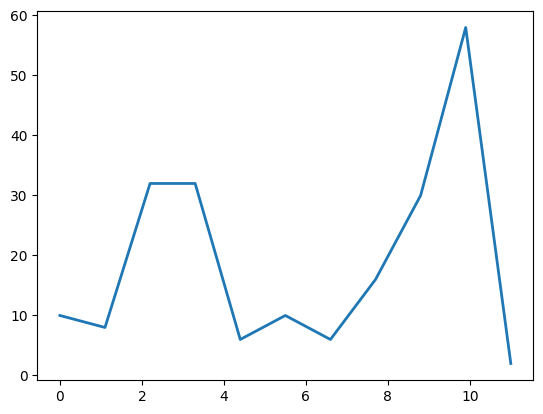

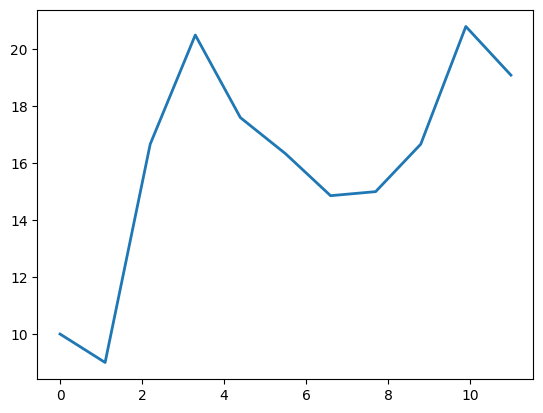

Exploded on  8 1
episode 11 score 2.00 average score 17.67
Won: False
[106, 146]
Exploded on  1 5
episode 12 score 38.00 average score 19.23
Won: False
[92, 106, 142, 76, 50, 50, 118, 36, 16, 54, 14, 93, 135, 85, 149, 1, 138, 132, 1, 3, 72, 131, 28]
Exploded on  1 5
episode 13 score 2.00 average score 18.00
Won: False
[156, 28]
Exploded on  2 8
episode 14 score 16.00 average score 17.87
Won: False
[20, 161, 159, 161, 0, 84, 71, 24, 0, 150, 2, 52]
Exploded on  1 4
episode 15 score 20.00 average score 18.00
Won: False
[146, 74, 143, 21, 68, 9, 38, 58, 110, 125, 26]
Exploded on  0 2
episode 16 score 12.00 average score 17.65
Won: False
[130, 118, 130, 19, 79, 88, 68, 27, 68, 4]
Exploded on  1 7
episode 17 score 2.00 average score 16.78
Won: False
[44, 32]
Exploded on  0 3
episode 18 score 42.00 average score 18.11
Won: False
[56, 116, 103, 54, 154, 110, 124, 141, 32, 121, 71, 30, 102, 98, 71, 75, 116, 14, 104, 140, 136, 158, 149, 122, 6]
Exploded on  8 6
episode 19 score 30.00 average sco

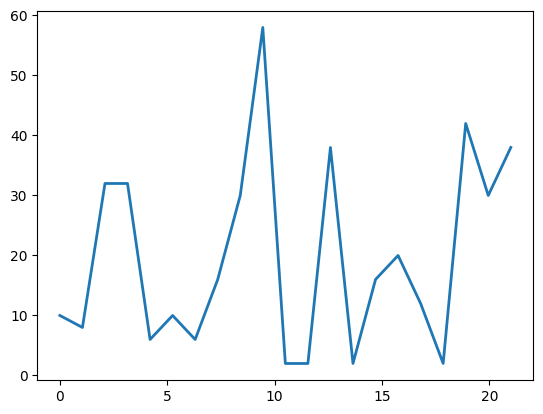

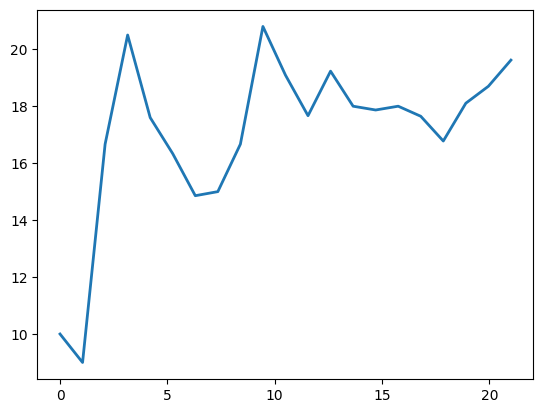

Exploded on  6 0
episode 21 score 2.00 average score 18.82
Won: False
[20, 108]
Exploded on  8 8
episode 22 score 22.00 average score 18.96
Won: False
[64, 155, 67, 7, 39, 9, 131, 40, 136, 111, 33, 160]
Exploded on  1 8
episode 23 score 6.00 average score 18.42
Won: False
[128, 9, 43, 34]
Exploded on  0 3
episode 24 score 14.00 average score 18.24
Won: False
[80, 154, 3, 54, 159, 65, 79, 6]
Exploded on  0 2
episode 25 score 2.00 average score 17.62
Won: False
[48, 4]
Exploded on  5 4
episode 26 score 76.00 average score 19.78
Won: False
[90, 107, 0, 137, 136, 27, 57, 60, 17, 29, 123, 88, 47, 9, 3, 107, 53, 73, 141, 135, 106, 103, 3, 117, 159, 154, 144, 41, 93, 96, 38, 106, 65, 97, 94, 82, 40, 100, 155, 72, 134, 41, 151, 130, 98]
Exploded on  8 6
episode 27 score 12.00 average score 19.50
Won: False
[116, 101, 69, 153, 72, 19, 156]
Exploded on  1 4
episode 28 score 8.00 average score 19.10
Won: False
[66, 129, 65, 144, 26]
Exploded on  8 2
episode 29 score 18.00 average score 19.07
Won:

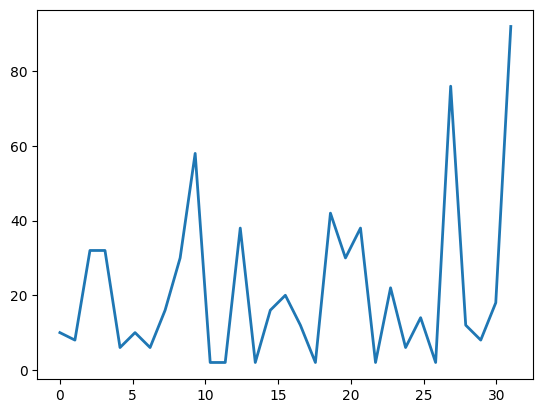

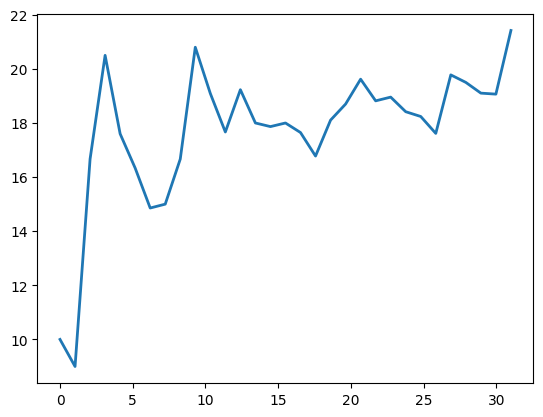

Exploded on  5 2
episode 31 score 9.00 average score 21.03
Won: False
[62, 8, 9, 47, 47, 132, 94]
Exploded on  3 4
episode 32 score 2.00 average score 20.45
Won: False
[154, 62]
Exploded on  1 3
episode 33 score 20.00 average score 20.44
Won: False
[134, 18, 140, 91, 47, 47, 96, 80, 80, 95, 82, 0, 47, 132, 65, 0, 24]
Exploded on  8 8
episode 34 score 34.00 average score 20.83
Won: False
[130, 107, 92, 103, 79, 103, 125, 106, 40, 117, 146, 107, 60, 58, 149, 37, 54, 67, 19, 120, 160]
Exploded on  2 3
episode 35 score 6.00 average score 20.42
Won: False
[36, 155, 121, 42]
Exploded on  0 1
episode 36 score 9.00 average score 20.11
Won: False
[42, 123, 78, 61, 134, 61, 2]
Exploded on  8 3
episode 37 score 22.00 average score 20.16
Won: False
[136, 87, 138, 114, 61, 116, 23, 73, 25, 8, 61, 35, 72, 61, 150]
Exploded on  0 5
episode 38 score 28.00 average score 20.36
Won: False
[44, 125, 86, 143, 135, 90, 110, 93, 145, 111, 72, 103, 61, 60, 10]
Exploded on  1 2
episode 39 score 18.00 average s

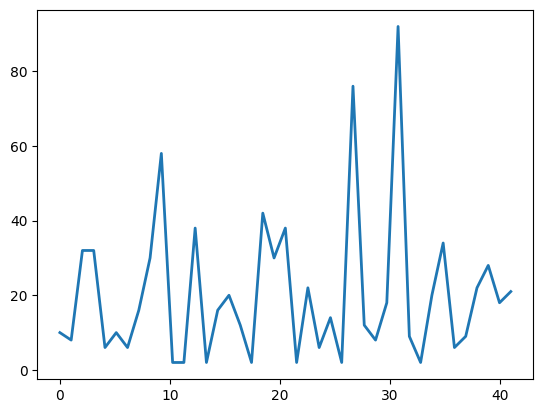

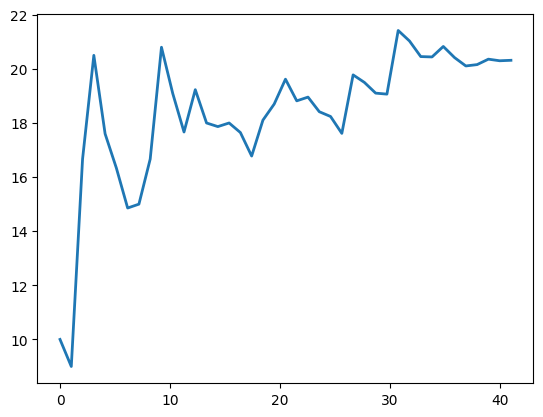

Exploded on  1 8
episode 41 score 35.00 average score 20.67
Won: False
[62, 125, 86, 92, 53, 18, 27, 78, 77, 50, 158, 159, 81, 71, 91, 37, 3, 36, 141, 37, 37, 37, 34]
Exploded on  0 2
episode 42 score 10.00 average score 20.42
Won: False
[64, 37, 30, 85, 44, 4]
Exploded on  7 0
episode 43 score 31.00 average score 20.66
Won: False
[44, 47, 96, 89, 37, 159, 37, 147, 131, 37, 20, 11, 62, 43, 115, 37, 23, 15, 88, 52, 126]
Exploded on  1 2
episode 44 score 10.00 average score 20.42
Won: False
[78, 67, 151, 149, 53, 22]
Exploded on  3 5
episode 45 score 18.00 average score 20.37
Won: False
[86, 49, 98, 114, 37, 38, 75, 74, 139, 64]
Exploded on  7 0
episode 46 score 38.00 average score 20.74
Won: False
[48, 14, 100, 37, 32, 37, 143, 30, 37, 37, 37, 37, 136, 54, 37, 37, 128, 53, 141, 131, 45, 58, 112, 28, 14, 25, 96, 47, 62, 47, 23, 47, 86, 56, 126]
Exploded on  5 6
episode 47 score 8.00 average score 20.48
Won: False
[52, 89, 65, 88, 102]
Exploded on  8 6
episode 48 score 4.00 average score 

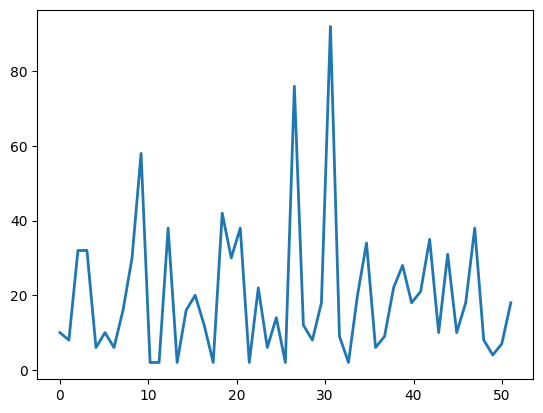

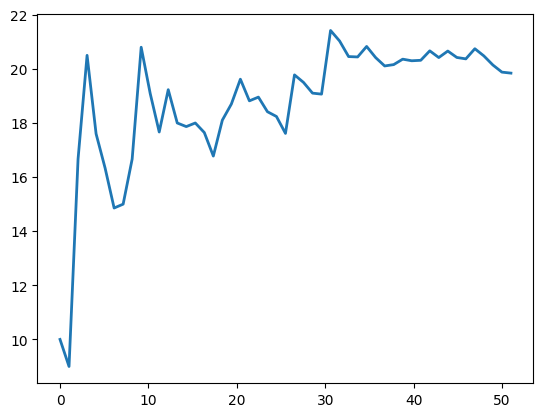

KeyboardInterrupt: ignored

In [13]:
#from dqn import Agent
import numpy as np
#import game
import tensorflow
import matplotlib.pyplot as plt

tensorflow.keras.utils.disable_interactive_logging()

board_size = 9
num_bombs = 20
print_moves = False

def gen_action_list(taken_actions = []):
    actions = []
    for i in range(board_size):
        for j in range(board_size):
            if (i, j, 'R') not in taken_actions:
                actions.append((i, j, 'R'))
            if (i, j, 'F') not in taken_actions:
                actions.append((i, j, 'F'))
    return actions

if __name__ == "__main__":
    

    actions = gen_action_list()
    """
    Input layer - 
    """
    
    env = MinesweeperGame(board_size, num_bombs, print_moves)

    try:
        n_games = int(input("How many games? (default=101)"))
    except:
        n_games = 101

    print("Number of games: ", n_games)

    try:
        n_experiments = int(input("How many games? (default=1)"))
    except:
        n_experiments = 1

    print("Number of experiments: ", n_experiments)


    for i in range(n_experiments):

        # gamma set to 0.0 from 0.99 for testing purposes
        agent = Agent(gamma=0.99, epsilon=1.0, alpha=0.0005, input_dims=81,
                      n_actions=len(actions), mem_size=100000, batch_size=256, epsilon_end=0.01)
        

        scores = []
        avg_scores = []
        eps_history = []

        '''
        f = open("result.txt","r+")
        eps_before = f.readline()
        if eps_before == "":
            eps_before = 0
        f.close()
        
        print(eps_before)
        '''
        for i in range(n_games):
            taken_actions = []
            done = False
            score = 0
            observation = env._reset(board_size,num_bombs)
            moves_taken = 0
            while not done:
                score = 0
                actions = gen_action_list(taken_actions)
                action = agent.choose_action(observation)
                if moves_taken == 0 and action % 2 == 1:
                    action -= 1
                env._make_move(actions[action])
                """        
                if action in taken_actions:
                  done = True
                  break
                """
                moves_taken += 2 if action not in taken_actions else -1
                
                #print("Moves taken: ", moves_taken)
                done, reward, observation_, is_won = env._get_state()
                score += reward + moves_taken
                agent.remember(observation, action, reward, observation_, done)
                observation = observation_
                agent.learn()
                taken_actions.append(action) #Not sure where to put this line
                

            eps_history.append(agent.epsilon)
            scores.append(score)

            avg_score = np.mean(scores[max(0, i-100):(i+1)])
            avg_scores.append(avg_score)

            #print('episode', i+int(eps_before), "score %.2f" % score, 'average score %.2f' % avg_score)
            print('episode', i, "score %.2f" % score,
                    'average score %.2f' % avg_score)
            print(f"Won: {is_won}")
            print(taken_actions)
            
            actions = gen_action_list()

            agent.refresh_actions()
        
            if i % 10 == 0 and i > 0:
                '''f = open("result.txt", "w+")
                f.write(str(i))
                f.close()
                '''
                x = np.linspace(0, i+1, i+1)

                # plot
                fig, ax = plt.subplots()
                fig_avg, ax_avg = plt.subplots()

                ax.plot(x, scores, linewidth=2.0)
                ax_avg.plot(x, avg_scores, linewidth=2.0)

                plt.show()

                agent.save_model()
          



test_game

In [ ]:
from unittest import TestCase
#from game import MinesweeperGame
import numpy as np

class TestMinesweeperGame(TestCase):

    def setUp(self):
        self.game = MinesweeperGame(9,10)

    def test__generate_board(self):
        #Check if two generated game boards aren't the same
        result1 = self.game.board
        result2 = self.game._generate_board(9,10)

        self.assertFalse(np.array_equal(result1, result2))

    def test__place_bombs(self):
        bomb_locations = self.game._place_bombs()
        num_bombs = len(bomb_locations)

        #Check that the number of bombs placed is correct
        self.assertEqual(num_bombs, 10)

        #Check that all bomb locations are valid
        for row, col in bomb_locations:
            self.assertLess(row, 9)
            self.assertLess(col, 9)
            self.assertEqual(self.game.board[row][col], -1)

    def test__get_neighbors(self):
        #Test the center cell
        neighbors = self.game._get_neighbors(1, 1)
        expected_neighbors = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1), (2, 2)]
        self.assertCountEqual(neighbors, expected_neighbors)

    def test__get_num_adjacent_bombs(self):
        #Ensure that the method doesn't count the bomb at given position as adjacent
        self.game.board = np.array([
            [0, 0, 0],
            [0, -1, 0],
            [0, 0, 0]
        ])
        num_adjacent_bombs = self.game._get_num_adjacent_bombs(1,1)
        self.assertEqual(num_adjacent_bombs, 0)

        # Ensure that the method count only the bombs at adjacent tiles
        self.game.board = np.array([
            [0, 0, -1],
            [-1, -1, -1],
            [-1, -1, -1]
        ])
        num_adjacent_bombs = self.game._get_num_adjacent_bombs(0, 0)
        self.assertEqual(num_adjacent_bombs, 2)

        # Ensure that the method checks every adjacent tiles
        self.game.board = np.array([
            [-1, -1, -1],
            [-1, 0, -1],
            [-1, -1, -1]
        ])
        num_adjacent_bombs = self.game._get_num_adjacent_bombs(1,1)
        self.assertEqual(num_adjacent_bombs, 8)


    def test__reveal(self):
        self.game.board = np.array([
            [1, 1, 1],
            [1, -1, 1],
            [1, 1, 1]
        ])

        self.game.hidden_board = np.array([
            ['-', '-', '-'],
            ['-', '-', '-'],
            ['-', '-', '-']
        ])

        #Revealing a non-bomb tile
        result = self.game._reveal(0, 0)
        self.assertEqual(result, 1)

        #Revealing a bomb tile and checking if revealing it ends the game
        result = self.game._reveal(1, 1)
        self.assertTrue(self.game.game_over)

        #Check the scoring system
        self.game.score = 0

        self.game.board = self.game.board = np.array([
            [0, 1, 1],
            [0, 1, -1],
            [0, 1, 1]
        ])

        self.game.hidden_board = np.array([
            ['-', '-', '-'],
            ['-', '-', '-'],
            ['-', '-', '-']
        ])

        self.game._reveal(0,0)
        self.assertEqual(self.game.score, 1)

        self.game._reveal(1,1)
        self.assertEqual(self.game.score, 0)

        self.game._reveal(0,2)
        self.assertEqual(self.game.score, 1)

        self.game._reveal(1,2)
        self.assertEqual(self.game.score, -9)


    def test__reveal_zeroes(self):
        # Revealing 0s
        self.game.revealed_tiles = 0
        self.game.board = self.game.board = np.array([
            [0, 0, 0],
            [1, 1, 1],
            [0, 1, 1]
        ])
        #print(self.game.board)

        self.game.hidden_board = np.array([
            ['-', '-', '-'],
            ['-', '-', '-'],
            ['-', '-', '-']
        ])
        #print(self.game.hidden_board)

        self.game.expected_board = np.array([
            [0, 0, 0],
            [1, 1, 1],
            ['-', '-', '-']
        ])

        result = self.game._reveal(0, 0)
        #self.assertTrue(np.array_equal(self.game.hidden_board, self.game.expected_board))

    def test__flag(self):
        #Test flagging a tile that has not been revealed
        self.game.hidden_board = np.array([
            ['-', '-', '-'],
            ['-', '-', '-'],
            ['-', '-', '-']
        ])

        result = self.game._flag(0,0)
        self.assertEqual(self.game.hidden_board[0][0], 'F')
        self.assertEqual(result, True)

        #Test unflagging a flagged tile
        result = self.game._flag(0,0)
        self.assertEqual(self.game.hidden_board[0][0], '-')
        self.assertEqual(result, True)

        #Test flagging an already revealed tile
        self.game.hidden_board = np.array([
            [1, '-', '-'],
            ['-', '-', '-'],
            ['-', '-', '-']
        ])
        result = self.game._flag(0,0)
        self.assertEqual(result, False)

        #Test flagging a bomb and scoring system
        self.game.board = np.array([
            [0, 0, 0],
            [0, 1, 1],
            [0, 1, -1]
        ])
        self.game.hidden_board = np.array([
            ['0', '0', '0'],
            ['0', '1', '1'],
            ['0', '1', '-']
        ])

        #Flagging an already revealed tile
        self.game.score = 0
        self.game._flag(0,0)
        self.assertEqual(self.game.score, -1)

        #Flagging a bomb
        self.game._flag(2,2)
        self.assertEqual(self.game.score, 0)

        #Unflagging a bomb
        self.game._flag(2,2)
        self.assertEqual(self.game.score, -1)


    def test__make_move(self):
        self.game.score = 0
        self.game.board = self.game.board = np.array([
            [0, 0, 0],
            [0, 1, 1],
            [0, 1, -1]
        ])

        self.game.hidden_board = np.array([
            ['-', '-', '-'],
            ['-', '-', '-'],
            ['-', '-', '-']
        ])

        #Reveal a zero tile
        action = (0,0,'R')

        self.game._make_move(action)

        self.assertEqual(int(self.game.hidden_board[0][0]), 0)
        self.assertEqual(int(self.game.hidden_board[0][1]), 0)
        self.assertEqual(int(self.game.hidden_board[0][2]), 0)
        self.assertEqual(int(self.game.hidden_board[1][0]), 0)
        self.assertEqual(int(self.game.hidden_board[2][0]), 0)

        #Reveal a non-zero tile
        action = (1,1,'R')

        self.game._make_move(action)
        self.assertEqual(int(self.game.hidden_board[1][1]), 1)

        #Flag a bomb
        action = (2,2,'F')

        self.game._make_move(action)
        self.assertEqual(self.game.hidden_board[2][2], 'F')

        #Unflag a bomb
        action = (2, 2,'F')

        self.game._make_move(action)
        self.assertEqual(self.game.hidden_board[2][2], '-')

        #Reveal a bomb
        action = (2,2,'R')

        self.game._make_move(action)
        self.assertEqual(self.game.hidden_board[2][2], '-')
        self.assertEqual(self.game.game_over, True)


    def test__get_state(self):
        self.game.score = 0
        self.game.board = np.array([
            [0, 0, 0],
            [0, 1, 1],
            [0, 1, -1]
        ])

        self.game.hidden_board = np.array([
            ['-', '-', '-'],
            ['-', '-', '-'],
            ['-', '-', '-']
        ])

        #Checking return statement after making no moves
        lost, score, board = self.game._get_state()

        self.game.expected_board = np.array([
            ['-', '-', '-'],
            ['-', '-', '-'],
            ['-', '-', '-']
        ])

        assert not lost
        self.assertEqual(score, 0)
        self.assertTrue(np.array_equal(board, self.game.expected_board))

        #Checking return statement after making a valid move
        action = (1,1,'R')
        self.game._make_move(action)
        lost, score, board = self.game._get_state()

        self.game.expected_board = np.array([
            ['-', '-', '-'],
            ['-', '1', '-'],
            ['-', '-', '-']
        ])

        assert not lost
        self.assertEqual(score, 1)
        self.assertTrue(np.array_equal(board, self.game.expected_board))

        #Checking return statement after losing a game
        action = (2,2,'R')
        self.game._make_move(action)
        lost, score, board = self.game._get_state()

        assert lost
        self.assertEqual(score, -9)
        self.assertTrue(np.array_equal(board, self.game.board))


    def test__reset(self):
        self.game._generate_board(9,10)
        lost, score, board = self.game._get_state()
        #print(lost, score, board)

        action = (0,0,'R')
        self.game._make_move(action)
        
        lost, score, board = self.game._get_state()
        #print(lost, score, board)

        self.game._reset(9,10)
        lost, score, board = self.game._get_state()
        #print(lost, score, board)
        
        assert not lost
        self.assertEqual(score, 0)
        self.assertTrue(np.array_equal(np.full((9, 9), '-'), self.game.hidden_board))






